In [1]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [4]:
from recom.model.MF import FunkSvd
from torch import optim

# init model
fsvd = FunkSvd(n_user, n_item, 32)
# define optimizer
opt = optim.SGD(fsvd.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
fsvd.fit(ratings_train_dict, opt, n_epochs=128, use_cuda=True, report_interval=32)
# return model to cpu
fsvd = fsvd.to('cpu')

from recom.eval.evaluator import generate_testing_candidates
# init testing candidates
cand_test = generate_testing_candidates(ratings_train_dict, ix2item)
pred_results = fsvd.pred_on_candidate_dict(cand_test)

Epoch: 32, Time: 5.58, /Average loss 4.66082
Epoch: 64, Time: 2.28, /Average loss 1.75364
Epoch: 96, Time: 2.09, /Average loss 1.47922
Epoch: 128, Time: 2.34, /Average loss 1.72293


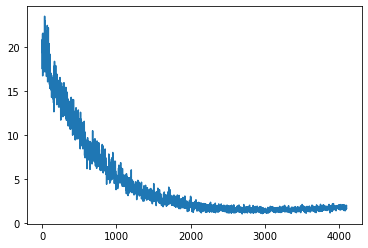

In [5]:
loss = fsvd.last_train_loss

import matplotlib.pyplot as plt

plt.plot(list(range(len(loss))), loss)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


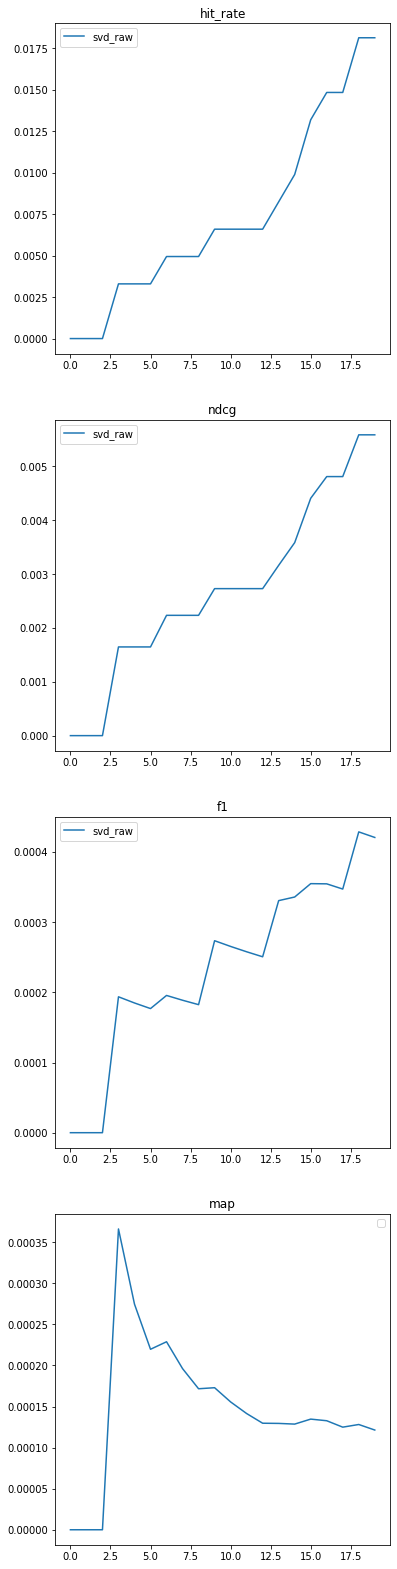

In [8]:
from recom.eval.metrics import hit_rate, ndcg, map, f1
import matplotlib.pyplot as plt

k = 20

metrics = {
    'hit_rate': hit_rate
    , 'ndcg': ndcg
    , 'f1': f1
    , 'map': map
}

preds = {
    'svd_raw': pred_results
}

fig, ax = plt.subplots(4, figsize=(6, 28))
for i, m_i in enumerate(metrics.keys()):
    val = [[metrics[m_i](ki, ratings_test_dict, pred) \
            for pred in preds.values()] \
           for ki in range(k)]
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()